#**PA3: Convolutional Neural Networks**

### **Introduction**
In this programming assignment, you will implement a Convolutional Neural Network (CNN) in Python with the Pytorch library to classify images of handwritten digits. As part of this process, you will write your own custom Convolution and MaxPooling layers. You will then use these layers to build a LeNet-5 network. You will train your LeNet-5 with the classic MNIST dataset, which is large enough to justify training with Mini-batch gradient descent. At the end of this assignment, you will see how the LeNet-5 can achieve high accuracy on handwritten digit image classication. After that, you will tweak this model to apply it to a different image classification problem.

### **Objective**

The main objective of this project is to practice implementing CNNs in PyTorch, including dataset loading, implementation of custom layers, training with gradient descent, and evaluation of trained models.

### **Instructions**

Differently than the previous assignments, this time you won't be told exactly where to write your code, but will be given class and function signatures that you can implement the way you want. However, you will still will have test cells with expected results, so you can check if your solution is on the right track.

### **Part 0: Import libraries**

Unlike the other practical assignments, in P4 you will not import `numpy`, but rather `torch`, to load PyTorch functionalities. You will also load the following auxiliary libraries:

- **torch.utils.data.DataLoader**: class for creating a data loader based on custom datasets.
- **torchvision.datasets**: built-in computer vision datasets.
- **torchvision.transforms**: set of functions for transforming images.
- **matplotlib**: main library for plotting graphs in Python.

In [53]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### **Part 1: Load the MNIST dataset**

Implement the `load_mnist` function to load the MNIST dataset with the `datasets.MNIST()` function from the `torchvision.datasets` module. This function will return dataset objects. You will need to create one of these objects for the training set and another for the test set. You can use `transforms.ToTensor()` and `transforms.Normalize()` to convert the images to tensors and normalize them, respectively. Apply these transformatins to both sets. When calling the `datasets.MNIST` function you will have to pass these two transformations into a single argument. You can use `transforms.Compose` to compose these two transformations into a single list of transformations.

After loading the train and test sets, create the `Dataloader` for each one of them. These dataloaders help you generating mini-batches at training time. Note the `batch_size` is an argument of the `load_mnist` funtion. Use this argument to create the dataloaders. Make sure to set `shuffle` parameters of the training dataloader to true, because we want to shuffle the data before every epoch of the mini-batch gradient descent. You don't need to shuffle the test set. Your function has to return two dataloders, one for the training set and another for the test set.

In [14]:
def load_mnist(batch_size=32):
    """
    Loads the MNIST dataset and returns DataLoader objects for the train and test sets.
    Applies ToTensor and Normalize transformations using MNIST's standard mean and std.
    """
    # Standard mean and standard deviation for the MNIST dataset
    mnist_mean = 0.1307
    mnist_std = 0.3081

    # Define the transformation pipeline
    transform = transforms.Compose([
        transforms.ToTensor(), # Converts PIL image or numpy.ndarray to tensor and scales pixels to [0, 1]
        transforms.Normalize((mnist_mean,), (mnist_std,)) # Normalizes tensor using the MNIST mean and std
    ])

    # Load the training dataset
    train_dataset = datasets.MNIST(
        root='./data',        # Directory to store the data
        train=True,           # Specify training dataset
        download=True,        # Download if not found locally
        transform=transform   # Apply the transformations
    )

    # Load the test dataset
    test_dataset = datasets.MNIST(
        root='./data',
        train=False,          # Specify test dataset
        download=True,
        transform=transform
    )

    # Create the DataLoader for the training set
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True          # Shuffle data before each epoch during training
    )

    # Create the DataLoader for the test set
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False         # No need to shuffle test data
    )

    # Return the created DataLoader objects
    return train_loader, test_loader

In [15]:
# Set random seed
torch.manual_seed(42)

# Load the MNIST dataset
train_loader, test_loader = load_mnist(batch_size=16)

# Print number of training and testing example
print(f"Number of training examples: {len(train_loader.dataset)}")
print(f"Number of testing examples: {len(test_loader.dataset)}")

# Get a single batch of data
data, target = next(iter(test_loader))

# Select an index to view an image
index = 10

# Plot part image
print(f"Sample pixels of image [{index}]: {data[index].numpy().squeeze()[10][:10]}")

Number of training examples: 60000
Number of testing examples: 10000
Sample pixels of image [10]: [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296  2.0450644   2.8087585 ]


**Expected result:**
<table style="width:50%">
  <tr>
    <td>Number of training examples</td>
    <td>60000</td>
  </tr>
  <tr>
    <td>Number of testing examples</td>
    <td>10000</td>
  </tr>
    <tr>
    <td>Sample pixels of image [10]</td>
    <td>[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296  2.0450644   2.8087585 ]</td>
  </tr>
</table>

## **Part 2: Convolutional Neural Network**

In Pytorch, neural network layers and complete models are implemented extending `torch.nn.Module` class. There are two main methods you need to implement when creating a new model: `__init__` to initialize the attributes of your model and `forward`, which will perform the forward pass of your model.

#### **2.1 A first convolution layer**

The first layer you will implement is the Convolution Layer with stride and padding. The main attributes you need to consider are the number of input channels `in_channels`, the number of output channels `out_channels`, the kernel size `kernel_size`, stride size `stride` and padding size `padding`.

1. `__init__`: Create the weights (filters) and a bias vector using the `torch.nn.Parameter` function. Your filter tensor should have size `(out_channels, in_channels, kernel_size, kernel_size)`. You can initialize the weights with the `torch.randn` function. Also save the paramteres values using attributes to use them in `forward`.

2. `forward(x)`: perform the forward pass on a mini-batch `x` of size `(batch_size, in_channels, in_height, in_width)`. This operation has to support padding (see `torch.nn.functional.pad`) and strides of any sizes. For this, you will have to compute the output width $w_o$ and $h_o$ using the formula we saw in class:

$
\begin{align}
w_o = \frac{w_i + 2p - f}{s} + 1 \\
h_o = \frac{h_i + 2p - f}{s} + 1
\end{align}
$

where $w_i$ is the input image width, $h_i$ is the input image height, $p$ is the padding size, $f$ is the filter size and $s$ is the stride size.

With $w_o$ and $h_o$ computed, you can implement the convolution with 4 for loops: 1 over the batch size, 1 over the number of filters, 1 over the output height and 1 over the output width. Make sure your output tensor is of size `(batch_size, out_channels, out_height, out_width)`




In [16]:
# Set the random seed here to ensure reproducible weight initialization
torch.manual_seed(42)

class CustomConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        """
        Initialize weights, bias, and hyperparameters of the convolutional layer

        Args:
            in_channels (int): number of input channels
            out_channels (int): number of output channels
            kernel_size (int): size of the kernel
            stride (int): stride size
            padding (int): padding size
        """
        # First, call the constructor of the parent class (nn.Module)
        super(CustomConv2d, self).__init__()

        # Store hyperparameters as instance attributes for use in the forward pass
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Initialize the weights (filters) as a learnable parameter.
        # Shape: (number of filters, input channels, kernel height, kernel width)
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))

        # Initialize the bias for each output channel as a learnable parameter.
        # Shape: (number of filters)
        self.bias = nn.Parameter(torch.randn(out_channels))

    def forward(self, x):
        """
        Perform the forward pass of a convolution layer on a mini-batch x

        Args:
            x (torch.Tensor): mini-batch of images of size (batch_size, in_channels, in_height, in_width)

        Returns:
            torch.Tensor: output of the convolutional layer of size (batch_size, out_channels, out_height, out_width)
        """
        # Apply padding to the input tensor
        x_padded = F.pad(x, (self.padding, self.padding, self.padding, self.padding))

        # Get dimensions from the padded input tensor
        batch_size, _, in_height, in_width = x_padded.shape

        # Calculate the dimensions of the output feature map using the provided formula
        out_height = (in_height - self.kernel_size) // self.stride + 1
        out_width = (in_width - self.kernel_size) // self.stride + 1

        # Create an empty tensor to store the output
        output = torch.zeros(batch_size, self.out_channels, out_height, out_width)

        # Implement the convolution operation with 4 nested for loops
        for i in range(batch_size):          # Loop over each image in the batch
            for j in range(self.out_channels):   # Loop over each output channel (filter)
                for h in range(out_height):      # Loop over the output height
                    for w in range(out_width):   # Loop over the output width
                        # Define the top-left corner of the current patch
                        h_start = h * self.stride
                        w_start = w * self.stride

                        # Define the bottom-right corner
                        h_end = h_start + self.kernel_size
                        w_end = w_start + self.kernel_size

                        # Slice the input tensor to get the current receptive field (patch)
                        receptive_field = x_padded[i, :, h_start:h_end, w_start:w_end]

                        # Apply the j-th filter: element-wise product and sum
                        convolution_sum = torch.sum(receptive_field * self.weight[j])

                        # Add the corresponding bias and store the result
                        output[i, j, h, w] = convolution_sum + self.bias[j]

        # Return the final output tensor. This fixes the original error.
        return output

In [17]:
# Set random seed
torch.manual_seed(42)

# Create an instance of your custom convolution layer
custom_conv = CustomConv2d(in_channels=1, out_channels=6, kernel_size=5)

# Show output for a single example of the dataset
first_batch = next(iter(test_loader))[0]

# Pick one image in the mini-batch
first_image = first_batch[0]
output_custom_conv = custom_conv(first_image.unsqueeze(0))

# Output Sample
print("Output shape:", output_custom_conv.size())
print("Output sample:", output_custom_conv[:,:,0,0])

Output shape: torch.Size([1, 6, 24, 24])
Output sample: tensor([[-0.3627,  2.7504, -2.1521,  1.8907, -2.4571,  1.1121]],
       grad_fn=<SelectBackward0>)


**Expected result:**
<table style="width:50%">
  <tr>
    <td>Output size</td>
    <td>[1, 6, 24, 24]</td>
  </tr>
  <tr>
    <td>Output sample</td>
    <td>[[-0.3627,  2.7504, -2.1521,  1.8907, -2.4571,  1.1121]]</td>
  </tr>
</table>

In [18]:
# Set random seed
torch.manual_seed(42)

# Create an instance of your custom convolution layer
custom_conv = CustomConv2d(in_channels=1, out_channels=6, kernel_size=5)

# Compare with pytorch's conv2d Layer
pytorch_conv = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)

# Forward pass of both networks
first_batch = next(iter(test_loader))[0]

# Measure time
t1 = time.perf_counter()
output_custom_conv = custom_conv(first_batch)
t2 = time.perf_counter()

print(f"Time taken by custom conv: {t2-t1} seconds")

t1 = time.perf_counter()
output_pytorch_conv = pytorch_conv(first_batch)
t2 = time.perf_counter()

print(f"Time taken by pytorch conv: {t2-t1} seconds")

Time taken by custom conv: 3.555800800999805 seconds
Time taken by pytorch conv: 0.001209921000054237 seconds


**Expected result:**
<table style="width:50%">
  <tr>
    <td>Time taken by custom conv</td>
    <td>3.8795 seconds</td>
  </tr>
  <tr>
    <td>Time taken by pytorch conv</td>
    <td>0.0022 seconds</td>
  </tr>
</table>

#### **2.2 Vectorizing the convolution operation**

As showed in the experiment above, implementing convolutions with 4 for loops is too slow. A single mini-batch of size 16 is taking more than 3 seconds to execute, so training on the entire MNIST dataset would take approximately $15 * (60000/3) = 20000\ seconds = 5.5\ hours$. This is a very long time considering the MNIST images are only 28x28 pixels large. We can reduce this time considerably implementing the convolution operation with vectorization (as the Pytorch implementation). To do that, we need to first generate the chunks for each convolution step and then multiply them by the kernel in parallalel.  In the next cell, change your `CustomConv2d` cell to use vectorization. You can use Pytorch's `torch.nn.functional.unfold` function to generate the chuncks for each concolution step. The `view` method of tensors might useful here too, to reshape the tensors.


In [19]:
# Set the random seed for reproducibility
torch.manual_seed(42)

class CustomConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(CustomConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.randn(out_channels))

    def forward(self, x):
        batch_size, _, in_height, in_width = x.shape

        # Calculate output dimensions
        out_height = (in_height + 2 * self.padding - self.kernel_size) // self.stride + 1
        out_width = (in_width + 2 * self.padding - self.kernel_size) // self.stride + 1

        # Extract patches using unfold
        # Shape: (N, C_in * K * K, L), where L = H_out * W_out
        patches = F.unfold(x, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride)

        # Reshape weights for matrix multiplication
        # Shape: (C_out, C_in * K * K)
        reshaped_weight = self.weight.view(self.out_channels, -1)

        # Perform convolution via matrix multiplication
        # Shape: (N, C_out, L)
        conv_result = reshaped_weight.matmul(patches)

        # Add bias (reshaped for broadcasting)
        # Shape: (1, C_out, 1) -> broadcasts to (N, C_out, L)
        bias_reshaped = self.bias.view(1, self.out_channels, 1)
        output_biased = conv_result + bias_reshaped

        # Reshape output to image format
        # Shape: (N, C_out, H_out, W_out)
        output = output_biased.view(batch_size, self.out_channels, out_height, out_width)

        return output

In [20]:
# Set random seed
torch.manual_seed(42)

# Create an instance of your custom convolution layer
custom_conv = CustomConv2d(in_channels=1, out_channels=6, kernel_size=5)

# Show output for a single example of the dataset
first_batch = next(iter(test_loader))[0]

# Pick one image in the mini-batch
first_image = first_batch[0]
output_custom_conv = custom_conv(first_image.unsqueeze(0))

# Output sample
print("Output shape:", output_custom_conv.size())
print("Output sample:", output_custom_conv[:,:,0,0])

Output shape: torch.Size([1, 6, 24, 24])
Output sample: tensor([[-0.3627,  2.7504, -2.1521,  1.8907, -2.4571,  1.1121]],
       grad_fn=<SelectBackward0>)


**Expected result:**
<table style="width:50%">
  <tr>
    <td>Output size</td>
    <td>[1, 6, 24, 24]</td>
  </tr>
  <tr>
    <td>Sample output</td>
    <td>[[-0.3627,  2.7504, -2.1521,  1.8907, -2.4571,  1.1121]]</td>
  </tr>
</table>

In [21]:
# Set random seed
torch.manual_seed(42)

# Create an instance of your custom convolution layer
custom_conv = CustomConv2d(in_channels=1, out_channels=6, kernel_size=5)

# Compare with pytorch's conv2d Layer
pytorch_conv = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)

# Forward pass of both networks
first_batch = next(iter(test_loader))[0]

# Measure time
t1 = time.perf_counter()
output_custom_conv = custom_conv(first_batch)
t2 = time.perf_counter()

print(f"Time taken by custom conv: {t2-t1} seconds")

t1 = time.perf_counter()
output_pytorch_conv = pytorch_conv(first_batch)
t2 = time.perf_counter()

print(f"Time taken by pytorch conv: {t2-t1} seconds")

Time taken by custom conv: 0.002405941000006351 seconds
Time taken by pytorch conv: 0.000895635000006223 seconds


**Expected result:**
<table style="width:50%">
  <tr>
    <td>Time taken by custom conv</td>
    <td>0.0031 seconds</td>
  </tr>
  <tr>
    <td>Time taken by pytorch conv</td>
    <td>0.0008 seconds</td>
  </tr>
</table>

#### **2.3 MaxPool Layer**

Now that you have a vectorized convolution layer, follow the same idea to implement a custom max pool layer. Remeber that this layer does not have weights. You can use the `torch.max` function to pool out the maximum values after generating the convolution image chuncks.


In [42]:
class CustomMaxPool2d(torch.nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        """
        Initialize the hyperparameters of the max pooling layer

        Args:
            kernel_size (int): size of the pooling window
            stride (int): stride size. Defaults to kernel_size if None.
            padding (int): padding size
        """
        super(CustomMaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, x):
        """
        Perform the max pooling operation on a mini-batch x using F.unfold

        Args:
            x (torch.Tensor): mini-batch of images of size (batch_size, in_channels, in_height, in_width)

        Returns:
            torch.Tensor: output of the max pooling layer of size (batch_size, channels, out_height, out_width)
        """
        batch_size, channels, in_height, in_width = x.shape

        out_height = (in_height + 2 * self.padding - self.kernel_size) // self.stride + 1
        out_width = (in_width + 2 * self.padding - self.kernel_size) // self.stride + 1

        patches = F.unfold(x, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride)

        patches = patches.view(batch_size, channels, self.kernel_size * self.kernel_size, out_height * out_width)

        max_values, _ = torch.max(patches, dim=2)

        output = max_values.view(batch_size, channels, out_height, out_width)

        return output

In [43]:
# Set random seed
torch.manual_seed(42)

# Create an instance of your custom max pooling layer
custom_maxpool = CustomMaxPool2d(kernel_size=2, stride=2)

# Pass the output of the convolutional layer through the pooling layer
output_custom_maxpool = custom_maxpool(output_custom_conv)

# Output sample
print("Output shape:", output_custom_maxpool.size())
print("Output sample:", output_custom_maxpool[0,:,0,0])

Output shape: torch.Size([16, 6, 12, 12])
Output sample: tensor([ 1.9269,  0.4982, -0.0801,  1.9378,  0.8503,  1.5644])


**Expected result:**
<table style="width:50%">
  <tr>
    <td>Output size</td>
    <td>[16, 6, 12, 12]</td>
  </tr>
  <tr>
    <td>Sample output</td>
    <td>[ 1.0448,  1.8319,  0.7205, -0.1121, -0.0309, -0.1503]</td>
  </tr>
</table>

#### **2.4 LeNet-5**

In this section, you will use your custom convolution and pooling layers to implement the variation of LeNet-5 we saw in class (see image below). Similarly to implementing layers, in Pytorch you can create entire models by extending the `torch.nn.module`. You just have to instantiate your layers as attributes in the `__init__` function and implement the full forward pass in the `forward(x)` function. In the forward function, you will pass the input $x$ though the sequence of layers following the specification of the network, which will produce a final prefiction $\hat{y}$ at the end. Your forward function has to return this prection $\hat{y}$. Use the pytorch `torch.nn.functional.relu` funtion to add the ReLU non-linearity to your convolutional hidden layers.

**In Pytorch, it is good practice to not add the softmax (or logistic)classification head as part of the model, since Pytorch can optimize training by computing the softmax/logistic activation as part of the loss function.**

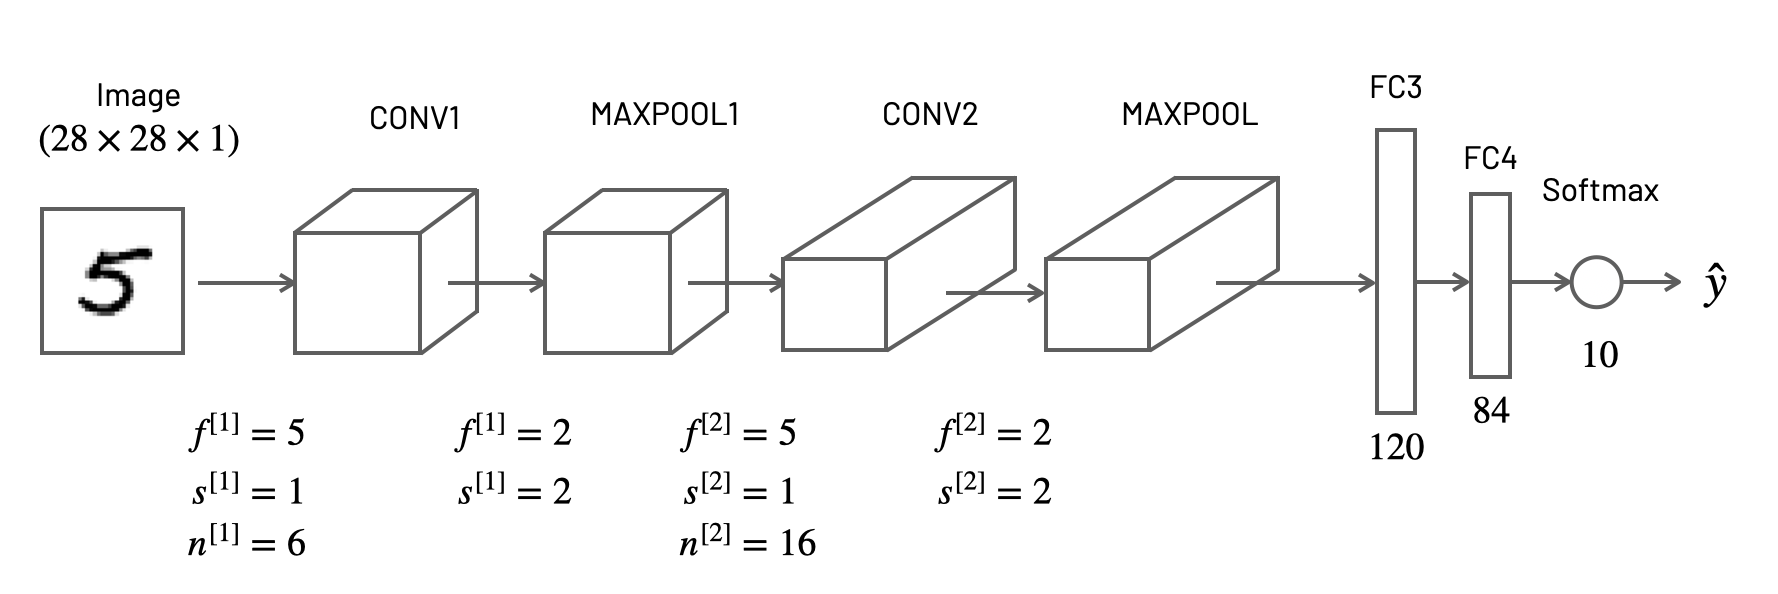


In [44]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolutional layers using custom implementations
        self.conv1 = CustomConv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool1 = CustomMaxPool2d(kernel_size=2, stride=2)
        self.conv2 = CustomConv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = CustomMaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers using PyTorch's nn.Linear
        self.fc1 = nn.Linear(16 * 4 * 4, 120) # Input features = 16 filters * 4x4 output size from pool2
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # Output features = 10 classes (digits 0-9)

    def forward(self, x):
        # Sequence: Conv -> ReLU -> Pool
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # Flatten the output for the linear layers
        x = torch.flatten(x, 1)

        # Sequence: Linear -> ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Final linear layer (logits output)
        logits = self.fc3(x)
        return logits

In [45]:
# Set random seed
torch.manual_seed(42)

# Create an instance of your LeNet5 model
model = LeNet5()

# Select a single example from the test dataset
example_image, example_label = next(iter(test_loader))
example_image = example_image[0]  # Take the first image from the batch
example_label = example_label[0]

# Pass the example through the model
output = model(example_image.unsqueeze(0))  # Add a batch dimension

# Get the predicted class
predicted_class = torch.argmax(output).item()

# Print the results
print(f"Example Image Label: {example_label}")
print(f"Predicted Class: {predicted_class}")

# You can also print the output probabilities if needed
print(f"Output Probabilities: {torch.nn.functional.softmax(output, dim=1)}")

Example Image Label: 7
Predicted Class: 5
Output Probabilities: tensor([[4.4402e-06, 4.9075e-10, 2.3634e-02, 1.0730e-10, 1.3650e-07, 9.6639e-01,
         2.9831e-03, 9.2747e-04, 6.0459e-03, 1.3411e-05]],
       grad_fn=<SoftmaxBackward0>)


**Expected result:**
<table style="width:50%">
  <tr>
    <td>Example Image Label</td>
    <td>7</td>
  </tr>
  <tr>
    <td>Predicted Class</td>
    <td>5</td>
  </tr>
    <tr>
    <td>Output Probabilities</td>
    <td>[[4.4402e-06, 4.9075e-10, 2.3634e-02, 1.0730e-10, 1.3650e-07, 9.6639e-01, 2.9830e-03, 9.2747e-04, 6.0458e-03, 1.3411e-05]]</td>
  </tr>
</table>

## **Part 3: Training**

Now that you have your LeNet-5 defined, it's time to train it with mini-batch gradient descent. Fill out the `train` function above specifing an Adam [optimizer](https://pytorch.org/docs/stable/optim.html), a Categorical CrossEntropy [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) (also called criterion). Then write the loop to iterate on the number of epochs and, inside the epochs loop, write the loop to iterate on the number of batches. In Pytorch, the dataloader is an iterator, so you can iterate on each mini-batch with `for (x_t,y_t) in train_loader`. For each batch:

1. Reset the gradients with the [torch.optim.Optimizer.zero_grad](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html).
2. Run forward pass for the current mini-batch $x^{t}$ to get the prediction $y^{t}$
3. Compute the loss with the `critetion` object
4. Run backward pass from the loss value computed in the previous step (3.)
5. Update the weights of the model with the [torch.optim.Optimizer.step](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html)
6. Print the average loss after each 100 mini-batches




In [54]:
def train(model, train_loader, epochs=5, lr=0.001):
    """
    Train the model with the Adam optimizer on the training set

    Args:
      model (torch.nn.Module): the model to train
      train_loader (torch.utils.data.DataLoader): the training set loader
      epochs (int): number of epochs
      lr (float): learning rate

    Returns:
      losses (list) : list of average losses after every 100 batches
    """
    # Set the model to training mode
    model.train()

    # Define the loss function (criterion) - CrossEntropyLoss combines LogSoftmax and NLLLoss
    criterion = nn.CrossEntropyLoss()

    # Define the optimizer - Adam is a popular choice
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    running_loss = 0.0
    print_every = 100 # How often to print the loss

    # Loop over the dataset multiple times (epochs)
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print("-" * 10)

        # Loop over the batches provided by the DataLoader
        for i, (inputs, labels) in enumerate(train_loader):

            # 1. Reset the gradients accumulated from the previous batch
            optimizer.zero_grad()

            # 2. Run forward pass: compute the model output (logits) for the batch
            outputs = model(inputs)

            # 3. Compute the loss between the outputs and the true labels
            loss = criterion(outputs, labels)

            # 4. Run backward pass: compute gradients of the loss w.r.t model parameters
            loss.backward()

            # 5. Update the weights of the model using the computed gradients
            optimizer.step()

            # Accumulate the loss for printing statistics
            running_loss += loss.item()

            # 6. Print the average loss every `print_every` mini-batches
            if (i + 1) % print_every == 0:
                avg_loss = running_loss / print_every
                print(f"Batch {i+1}/{len(train_loader)} - Average Loss: {avg_loss:.4f}")
                losses.append(avg_loss)
                running_loss = 0.0 # Reset running loss after printing

    print("Finished Training")
    return losses

Epoch 1/5
----------
Batch 100/3750 - Average Loss: 1.6982
Batch 200/3750 - Average Loss: 0.5936
Batch 300/3750 - Average Loss: 0.4285
Batch 400/3750 - Average Loss: 0.3964
Batch 500/3750 - Average Loss: 0.3396
Batch 600/3750 - Average Loss: 0.3232
Batch 700/3750 - Average Loss: 0.3672
Batch 800/3750 - Average Loss: 0.3621
Batch 900/3750 - Average Loss: 0.2528
Batch 1000/3750 - Average Loss: 0.2666
Batch 1100/3750 - Average Loss: 0.2264
Batch 1200/3750 - Average Loss: 0.2287
Batch 1300/3750 - Average Loss: 0.3083
Batch 1400/3750 - Average Loss: 0.2213
Batch 1500/3750 - Average Loss: 0.1957
Batch 1600/3750 - Average Loss: 0.2205
Batch 1700/3750 - Average Loss: 0.1712
Batch 1800/3750 - Average Loss: 0.2451
Batch 1900/3750 - Average Loss: 0.1494
Batch 2000/3750 - Average Loss: 0.2026
Batch 2100/3750 - Average Loss: 0.1817
Batch 2200/3750 - Average Loss: 0.1695
Batch 2300/3750 - Average Loss: 0.1664
Batch 2400/3750 - Average Loss: 0.1966
Batch 2500/3750 - Average Loss: 0.1770
Batch 2600/37

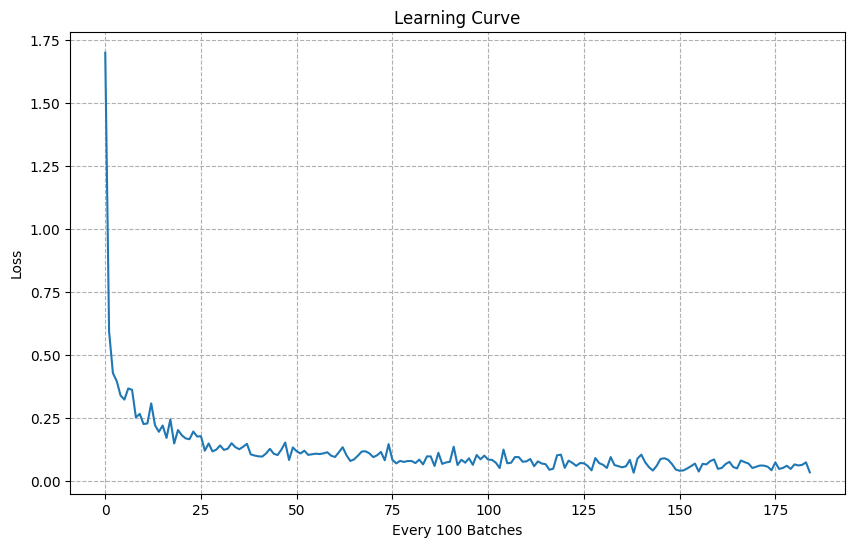

In [57]:
# Set random seed
torch.manual_seed(42)

# Instantiate and train the model
model = LeNet5()
losses = train(model, train_loader, epochs=5)

# Plot figure
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Learning Curve')
plt.xlabel('Every 100 Batches')
plt.ylabel('Loss')
plt.grid(True, linestyle='--')
plt.show()

**Expected result:**

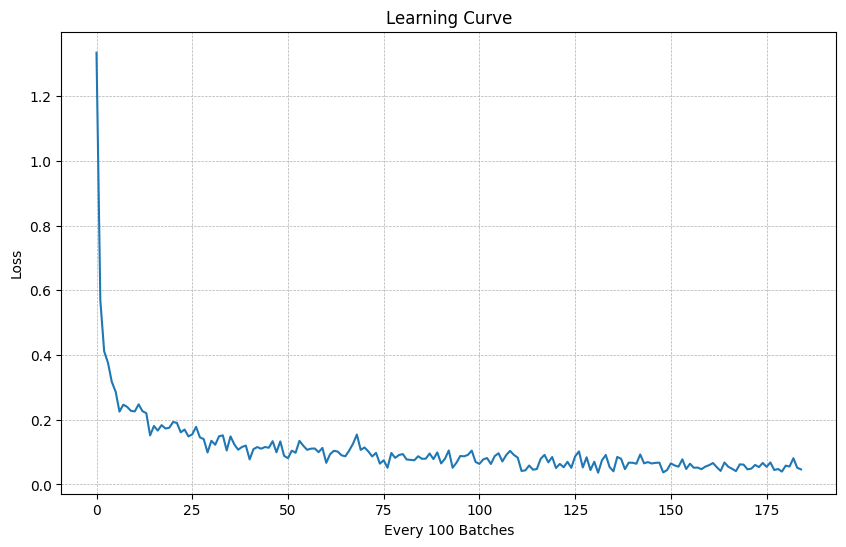

## **Part 4: Evaluation**

The last step is to evaluate your model. The MNIST is a balanced dataset and all classes have the same importance, so we can use accuracy for this task. Implement the following function to compute the accuracy of your LeNet-5 on the MNIST test set.

In [58]:
def evaluate(model, test_loader):
    """
    Compute the accuracy of the model on the test set.

    Args:
        model (torch.nn.Module): The model to evaluate.
        test_loader (torch.utils.data.DataLoader): The data loader for the test set.

    Returns:
        float: The accuracy of the model on the test set (as a percentage).
    """
    # Set the model to evaluation mode (disables dropout, batchnorm updates, etc.)
    model.eval()

    correct = 0
    total = 0

    # We don't need to calculate gradients during evaluation
    with torch.no_grad():
        # Iterate over the batches in the test loader
        for inputs, labels in test_loader:
            # Get the model's predictions (logits) for the current batch
            outputs = model(inputs)

            # Find the class with the highest score (predicted class)
            # torch.max returns (max_value, max_indices)
            _, predicted = torch.max(outputs.data, 1)

            # Update the total number of samples processed
            total += labels.size(0)

            # Update the number of correctly predicted samples
            correct += (predicted == labels).sum().item()

    # Calculate the accuracy
    accuracy = 100 * correct / total
    return accuracy

In [59]:
# Evaluate the model
accuracy = evaluate(model, test_loader)
print(f'Accuracy on test set: {accuracy:.2f}%')

Accuracy on test set: 97.91%


**Expected result:**
<table style="width:50%">
  <tr>
    <td>Accuracy on test set</td>
    <td>97.73%</td>
  </tr>
</table>

## **Part 5: Challenge (Optional)**

If you implemented your model correctly, it should have achieve a accuracy higher than 95%. Can you improve the network to do better? Write a model in PyTorch trying to improve the test accuracy. The best model will get an extra point! You can try any idea we've seen in the course so far, such as increasing the model, different pooling layers, regularization (L1, L2, Dropout), etc. Report the results of your model using the `evaluate` function above.


Training Optional Model:
Epoch 1/5
----------
Batch 100/3750 - Average Loss: 0.7809
Batch 200/3750 - Average Loss: 0.3709
Batch 300/3750 - Average Loss: 0.2877
Batch 400/3750 - Average Loss: 0.2510
Batch 500/3750 - Average Loss: 0.1958
Batch 600/3750 - Average Loss: 0.1942
Batch 700/3750 - Average Loss: 0.1714
Batch 800/3750 - Average Loss: 0.2126
Batch 900/3750 - Average Loss: 0.1728
Batch 1000/3750 - Average Loss: 0.1411
Batch 1100/3750 - Average Loss: 0.1391
Batch 1200/3750 - Average Loss: 0.1474
Batch 1300/3750 - Average Loss: 0.1510
Batch 1400/3750 - Average Loss: 0.1335
Batch 1500/3750 - Average Loss: 0.1472
Batch 1600/3750 - Average Loss: 0.1189
Batch 1700/3750 - Average Loss: 0.1168
Batch 1800/3750 - Average Loss: 0.1245
Batch 1900/3750 - Average Loss: 0.1096
Batch 2000/3750 - Average Loss: 0.1532
Batch 2100/3750 - Average Loss: 0.1188
Batch 2200/3750 - Average Loss: 0.1193
Batch 2300/3750 - Average Loss: 0.1003
Batch 2400/3750 - Average Loss: 0.1087
Batch 2500/3750 - Average 

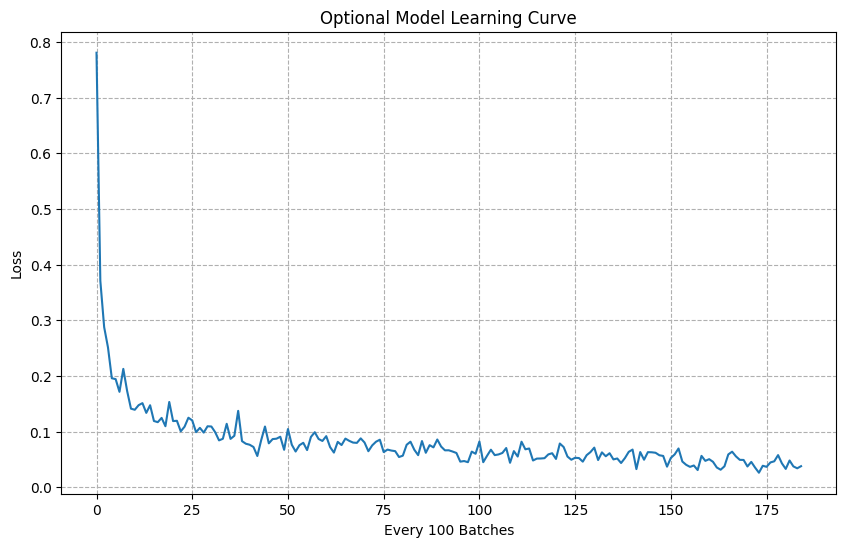


Evaluating Optional Model:
Accuracy of Optional Model on test set: 99.22%


In [60]:
class OptionalModel(torch.nn.Module):
    def __init__(self):
        super(OptionalModel, self).__init__()
        # Define convolutional block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1) # 3x3 kernel, padding=1 keeps size 28x28
        self.bn1 = nn.BatchNorm2d(32) # Batch Norm after Conv
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Reduces size to 14x14

        # Define convolutional block 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # padding=1 keeps size 14x14
        self.bn2 = nn.BatchNorm2d(64) # Batch Norm after Conv
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Reduces size to 7x7

        # Define fully connected layers
        # Input features = 64 channels * 7x7 image size after pooling
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.bn3 = nn.BatchNorm1d(128) # Batch Norm after Linear
        self.dropout = nn.Dropout(p=0.5) # Dropout for regularization
        self.fc2 = nn.Linear(128, 10) # Output layer for 10 digits

    def forward(self, x):
        # Pass through conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        # Pass through conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        # Flatten the output for the linear layers
        x = torch.flatten(x, 1) # Flatten all dimensions except batch

        # Pass through linear layers
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x) # Apply dropout before the final layer
        logits = self.fc2(x) # Output logits

        return logits

# --- Now you need to train and evaluate this new model ---

# Set random seed again for reproducibility if needed
torch.manual_seed(42)

# Instantiate the optional model
optional_model = OptionalModel()

# Train the optional model using the same train function
print("\nTraining Optional Model:")
optional_losses = train(optional_model, train_loader, epochs=5, lr=0.001) # Use the same training parameters or adjust

# Plot the learning curve for the optional model
plt.figure(figsize=(10, 6))
plt.plot(optional_losses)
plt.title('Optional Model Learning Curve')
plt.xlabel('Every 100 Batches')
plt.ylabel('Loss')
plt.grid(True, linestyle='--')
plt.show()


# Evaluate the optional model
print("\nEvaluating Optional Model:")
optional_accuracy = evaluate(optional_model, test_loader)
print(f'Accuracy of Optional Model on test set: {optional_accuracy:.2f}%')

### **Explanation of Changes in `OptionalModel`**

To improve upon the baseline LeNet-5 accuracy, I implemented the following modifications in the `OptionalModel`:

1.  **Increased Network Capacity:** I increased the number of filters in the convolutional layers (from 6 and 16 to 32 and 64, respectively) and the size of the first fully connected layer (to 128 units). This gives the model more parameters to learn complex patterns.
2.  **Modern Convolution Blocks:** I switched to smaller 3x3 kernels with `padding=1` in the convolutional layers. This is a common practice in modern CNNs that helps preserve spatial dimensions better than larger kernels without padding.
3.  **Batch Normalization:** I added `BatchNorm2d` layers after each convolutional layer and `BatchNorm1d` after the first fully connected layer (before the ReLU activation). Batch Normalization helps stabilize the training process, potentially allowing for faster convergence and acting as a form of regularization.
4.  **Dropout Regularization:** I included a `Dropout` layer (`p=0.5`) before the final fully connected layer. Dropout helps prevent overfitting by randomly setting a fraction of neuron outputs to zero during training, forcing the network to learn more robust features.

These changes aim to create a deeper, more regularized model capable of achieving higher accuracy on the MNIST test set compared to the standard LeNet-5 implementation.